In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) \n[GCC 9.4.0]'

In [3]:
from cbf_opt import asif, cbf, dynamics
from refine_cbfs import cbf as refine_cbfs, dynamics as dynamics_hjr
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
from tqdm import tqdm
from refine_cbfs.utils import nominal_hjr_control
import numpy as np

In [4]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.animation as anim

In [5]:
class DubinsDynamics(dynamics.ControlAffineDynamics):

    
    def __init__(self, params, **kwargs):
        
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        self.v = params["v"]
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([self.v * jnp.cos(state[2]), self.v * jnp.sin(state[2]), 0])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 0, 1]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([
            [0, 0, self.v * jnp.sin(state[2])],
            [0, 0, -self.v * jnp.cos(state[2])], 
            [0, 0, 0]])

In [6]:
class DubinsCBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics: DubinsDynamics, params: dict = dict(), **kwargs) -> None:
        self.center = params["center"]
        self.r = params["r"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        return np.array([(state[0] - self.center[0]) ** 2 + (state[1] - self.center[1]) ** 2 - self.r ** 2])[0]

    def _grad_vf(self, state, time=0.0):
        return np.array([2 * (state[0] - self.center[0]), 2 * (state[1] - self.center[1]), 0])

In [7]:
def constraint_set(state):
    """A real-valud function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    bottom_left = jnp.array([4., 4.])
    length = jnp.array([2., 2.])
    return -jnp.min(jnp.array([state[0] - bottom_left[0], bottom_left[0] + length[0] - state[0], state[1] - bottom_left[1], bottom_left[1] + length[1] - state[1]]))


In [8]:
umin = -.5
umax = .5
dyn = DubinsDynamics({"v": 1.0, "dt": 0.05})
dubins_cbf = DubinsCBF(dyn, {"center": [5, 5], "r": jnp.sqrt(2.0)})

In [9]:
dyn_hjr = dynamics_hjr.HJControlAffineDynamics(dyn, control_space=hj.sets.Box(jnp.array([umin]), jnp.array([umax])))

state_domain = hj.sets.Box(lo=jnp.array([-5., -5., -jnp.pi]), hi=jnp.array([20., 20., jnp.pi]))
grid_resolution = (201, 201, 81) # can/should be increased if running on GPU, or if extra patient

In [10]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)

In [11]:
from refine_cbfs.utils import nominal_hjr_control

In [12]:
opt_ctrl = nominal_hjr_control.NominalControlHJ(dyn_hjr, grid, final_time=-40, time_intervals=101, solver_accuracy="low", padding=jnp.array([.2, .2, jnp.pi / 6]))

In [13]:
constraint_values = hj.utils.multivmap(constraint_set, jnp.arange(3))(grid.states)  # l(x)

In [14]:
cbf_table = dubins_cbf.vf(jnp.moveaxis(grid.states, -1, 0), 0.0)

In [15]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("very_high", value_postprocessor=backwards_reachable_tube(constraint_values))

In [16]:
# init_values = constraint_values
# initial_time = 0.
# final_time = -5.
# times = jnp.linspace(initial_time, final_time, 101)
# target_values_hjr = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)
# np.save("dubins/dubins_target_values_hjr.npy", target_values_hjr)
target_values_hjr = np.load('dubins/dubins_target_values_hjr.npy')

In [17]:
# init_values = cbf_table
# initial_time = 0.
# final_time = -10.
# times = jnp.linspace(initial_time, final_time, 201)
# target_values = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)
# np.save("dubins/dubins_target_values_wscbf.npy", target_values)
target_values = np.load('dubins/dubins_target_values_wscbf.npy')

In [18]:
import seaborn as sns

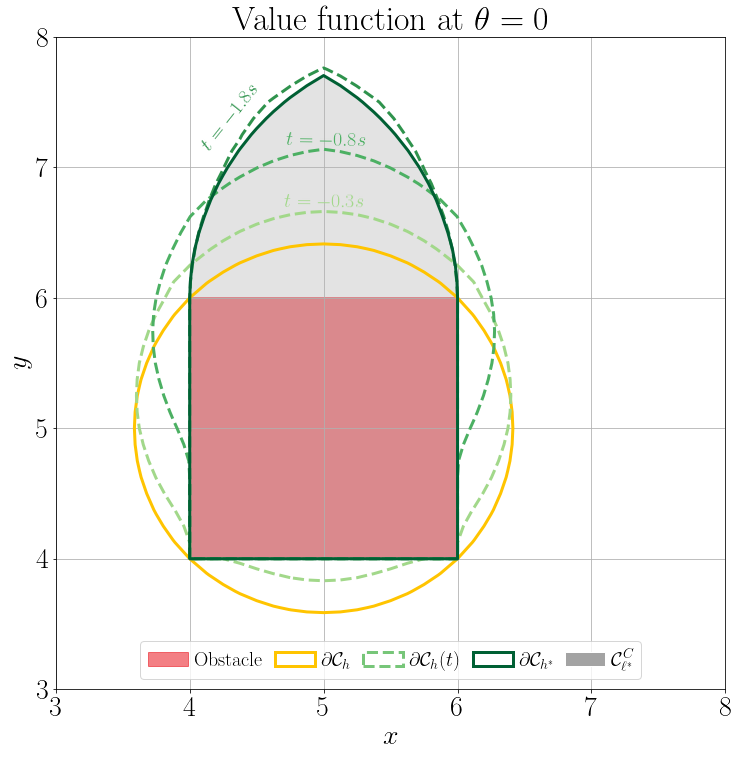

In [19]:
# sns.set_theme()
# plt.style.use('classic')
fig, ax = plt.subplots(1, 1, figsize=(12, 12 ))
blue_colors = sns.color_palette("YlGn", 9).as_hex()
gen_colors = sns.color_palette("bright", 9).as_hex()
proxy = [] 
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], constraint_values[..., 0], levels=[-10, 0], colors=gen_colors[3], alpha=0.5)
proxy += [plt.Rectangle((0,0),1,1, fc=gen_colors[3], ec=gen_colors[3], alpha=0.5) for pc in cs.collections]
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., 0], levels=[-10, 0], colors=gen_colors[7], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., 0], levels=[0], colors=gen_colors[-1], linewidths=3)
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[-1], fc='white', lw=3)
        for pc in cont.collections]

cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[5][..., 0], levels=[0], colors=blue_colors[3], linestyles ='dashed', linewidths=3)
a = ax.clabel(cs, cs.levels, inline=False, fmt="$t=-0.3s$", fontsize=20, inline_spacing=-10, manual=[(5, 6.5)])
for l in a:
        l.set_va('bottom')
# ax.clabel(cs, inline=False, rightside_up=False, fontsize=20, fmt='$t=-0.3 s$', inline_spacing=3, colors = 'k')
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[15][..., 0], levels=[0], colors=blue_colors[-4], linestyles ='dashed', linewidths=3)
contourlabel0 = ax.clabel(cs, inline=False, fontsize=20, fmt='$t=-0.8s$', inline_spacing=3, manual=[(5,7)])
for l in contourlabel0:
        l.set_va('bottom')
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[35][..., 0], levels=[0], colors=blue_colors[-3], linestyles ='dashed', linewidths=3)
proxy += [plt.Rectangle((0,0),1,1,ec = blue_colors[-5], fc='white', linestyle='dashed', lw=3)
        for pc in cs.collections]
contourlabel1 = ax.clabel(cs, inline=False, fontsize=20, fmt='$t=-1.8s$', inline_spacing=-30, manual=[(4.5, 7)])
for l in contourlabel1:
        l.set_va('bottom')

cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[-1][..., 0], levels=[0], colors=blue_colors[-1], linewidths=3)
proxy += [plt.Rectangle((0,0),1,1,ec = blue_colors[-1], fc='white', lw=3)
        for pc in cs.collections]


proxy += [plt.Rectangle((0,0),1,1,fc = gen_colors[7], ec='white')
        for pc in cs.collections]
ax.grid()
ax.set_xlabel("$x$")
# ax.text(contourlabel0)
# ax.text(contourlabel1)
ax.set_xlim([3, 8])
ax.set_ylim([3, 8])
ax.set_ylabel("$y$")
ax.set_title(r"Value function at $\theta=0$")
ax.legend(proxy, ["Obstacle", "$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$", "$\partial \mathcal{C}_{h^*}$", "$\mathcal{C}_{\ell^*}^C$"], prop={'size': 20}, ncol=5, loc='lower center', columnspacing=0.6, handletextpad=0.3)

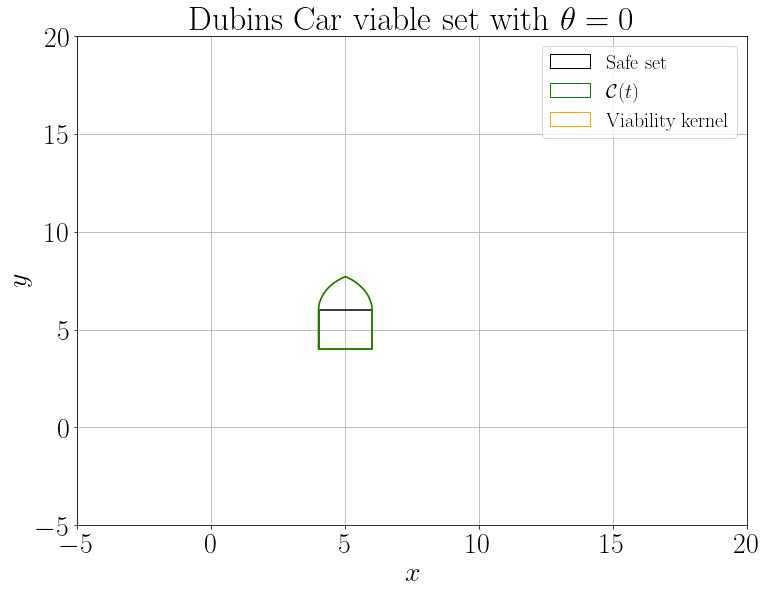

In [20]:
value_function = target_values
filename="dubins.mp4"


def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()
        
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], value_function[i][..., 0], levels=[0], colors='g')


fig, ax = plt.subplots(figsize=(12, 9))
proxy = [] 
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], constraint_values[..., 0], levels=[0], colors='k')
proxy += [plt.Rectangle((0,0),1,1,ec = 'k', fc='white') for pc in cs.collections]

cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], value_function[0][..., 0], levels=[0], colors='g')
proxy += [plt.Rectangle((0,0),1,1,ec = 'g', fc='white')
        for pc in cont.collections]
cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], value_function[-1][..., 0], levels=[0], colors='orange')
proxy += [plt.Rectangle((0,0),1,1,ec = 'orange', fc='white')
        for pc in cs.collections]
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title(r"Dubins Car viable set with $\theta=0$")
ax.legend(proxy, ["Safe set", "$\mathcal{C}(t)$", "Viability kernel"], prop={'size': 20})

render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, value_function.shape[0], interval=10)
animation.save("dubins/{}".format(filename), writer='ffmpeg', fps=30)

In [21]:
opt_ctrl = nominal_hjr_control.NominalControlHJNP(dyn_hjr, grid, final_time=-30, time_intervals=101, solver_accuracy="low", padding=jnp.array([.2, .2, jnp.pi / 6]))
# opt_ctrl.solve(target=jnp.array([10, 6, 0]))
# np.save("dubins/dubins_opt_ctrl_vfs.npy", opt_ctrl.tv_vf)
opt_ctrl.tv_vf = np.load("dubins/dubins_opt_ctrl_vfs.npy")

In [22]:
alpha = lambda x: 5 * x
tabular_cbf = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf.vf_table = np.array(target_values[-1])
dubins_asif_ws = asif.ControlAffineASIF(dyn, tabular_cbf, alpha=alpha, nominal_policy=opt_ctrl.get_nominal_control)
dubins_asif = asif.ControlAffineASIF(dyn, dubins_cbf, alpha=alpha, nominal_policy=opt_ctrl.get_nominal_control)

In [23]:
x0 = np.array([2, 3, 0])
states = [x0]
control = []
control_filt = []
control_filt_ws = []
x_filt = x0 
betas = []
states_filt = [x0]
x_filt_ws = x0
states_filt_ws = [x0]
vf_filt = [dubins_cbf.vf(x0, 0.)]
vf_filt_ws = [tabular_cbf.vf(x0, 0.)]
ts = np.arange(0, 10, .05)

x = x0
for i, t in enumerate(tqdm(ts)):  
    # if i % 5 == 0:
    input_nom = np.array(opt_ctrl.get_nominal_control(x, t))

    x = np.array(dyn.step(x, input_nom))
    x[2] = (x[2] + np.pi) % (2 * np.pi) - np.pi
    states.append(x)
    control.append(input_nom)

for i, t in enumerate(tqdm(ts)):   
    # if i % 5 == 0: 
    input_mod = np.atleast_1d(dubins_asif(x_filt))

    x_filt = np.array(dyn.step(x_filt, input_mod))
    x_filt[2] = (x_filt[2] + np.pi) % (2 * np.pi) - np.pi
    states_filt.append(x_filt)
    vf_filt.append(dubins_cbf.vf(x_filt, 0.))
    control_filt.append(input_mod)

for i, t in enumerate(tqdm(ts)):
    # if i % 5 == 0:
    input_mod_ws = np.atleast_1d(np.clip(dubins_asif_ws(x_filt_ws), umin, umax))

    x_filt_ws = np.array(dyn.step(x_filt_ws, input_mod_ws))
    x_filt_ws[2] = (x_filt_ws[2] + np.pi) % (2 * np.pi) - np.pi
    states_filt_ws.append(x_filt_ws)
    vf_filt_ws.append(tabular_cbf.vf(x_filt_ws, t))
    control_filt_ws.append(input_mod_ws)


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


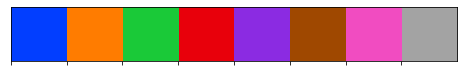

In [30]:
sns.palplot(sns.color_palette("bright", 8))

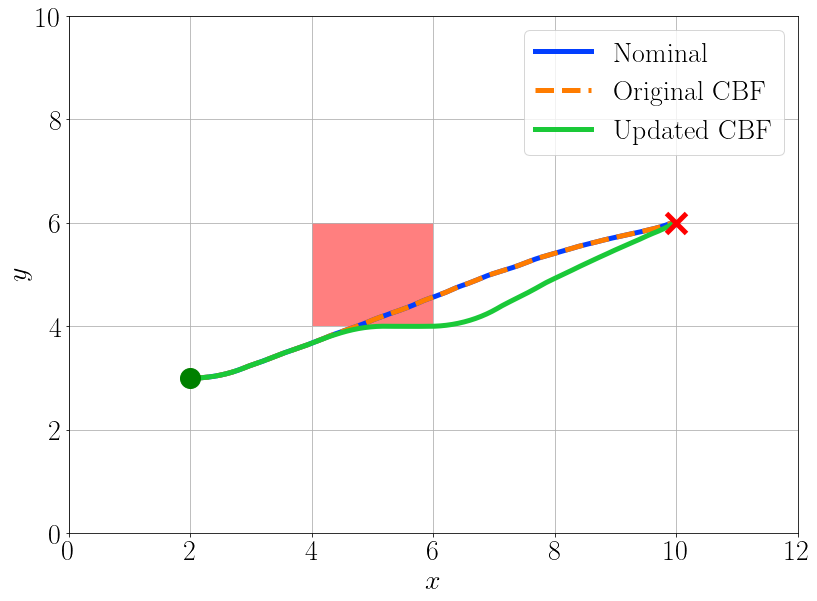

In [32]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.set_palette("bright")
# ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], value_function[-1][..., 0], levels=[0], colors='green')
ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], constraint_values[..., 0], levels=[-10, 0], colors='r', alpha=.5)

ax.set_xlim([0, 12])
ax.set_ylim([0, 10])
target = np.array([10., 6., 0.])

last_idx = np.linalg.norm(np.array(states)[:,:2] - target[:2], axis=1).argmin(axis=0)
last_idx_2 = np.linalg.norm(np.array(states_filt)[:,:2] - target[:2], axis=1).argmin(axis=0)
last_idx_3 = np.linalg.norm(np.array(states_filt_ws)[:,:2] - target[:2], axis=1).argmin(axis=0)
ax.plot(np.array(states)[:last_idx, 0], np.array(states)[:last_idx, 1], label='Nominal', linewidth=5)
ax.plot(np.array(states_filt)[:last_idx_2, 0], np.array(states_filt)[:last_idx_2, 1], '--', label='Original CBF', linewidth=5)
ax.plot(np.array(states_filt_ws)[:last_idx_3, 0], np.array(states_filt_ws)[:last_idx_3, 1], label='Updated CBF', linewidth=5)
ax.plot(states_filt[0][0], states_filt[0][1], 'o', color='green', markersize=20)
ax.plot(target[0], target[1], 'x', color='red', markersize=20, mew=5)


ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.grid()
ax.legend()
fig.tight_layout()

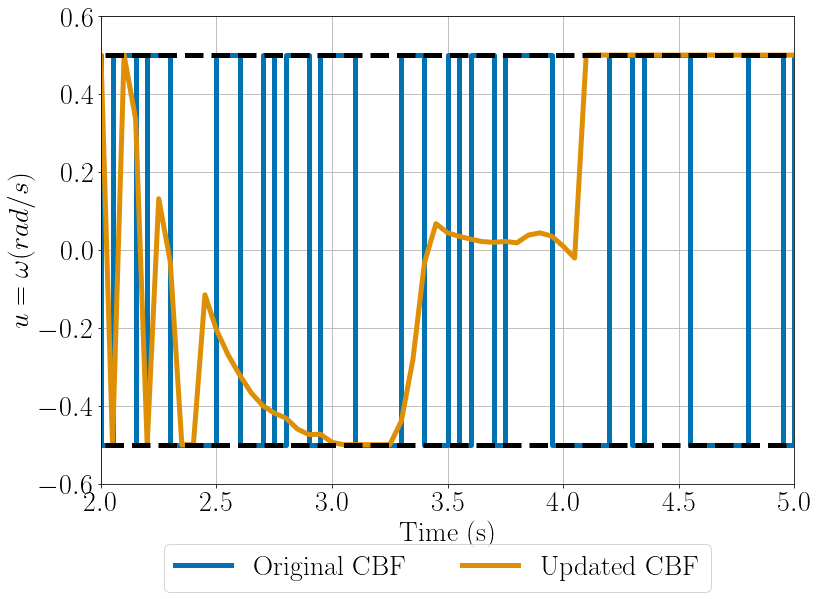

In [68]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.set_palette("colorblind")
ax.step(ts[:last_idx_2], control_filt[:last_idx_2], label='Original CBF', linewidth=5)
ax.plot(ts[:last_idx_3], control_filt_ws[:last_idx_3], label='Updated CBF', linewidth=5)
ax.plot(ts, np.ones_like(ts) * 0.5, '--k', linewidth=5)
ax.plot(ts, np.ones_like(ts) * -0.5, '--k', linewidth=5)
ax.set_xlim([2, 5])
ax.set_ylim([-.6, .6])
ax.set_xlabel("Time (s)")
ax.set_ylabel("$u=\omega (rad/s)$")
ax.legend(bbox_to_anchor=(0.9, -0.1), ncol=2)
ax.grid()
fig.tight_layout()

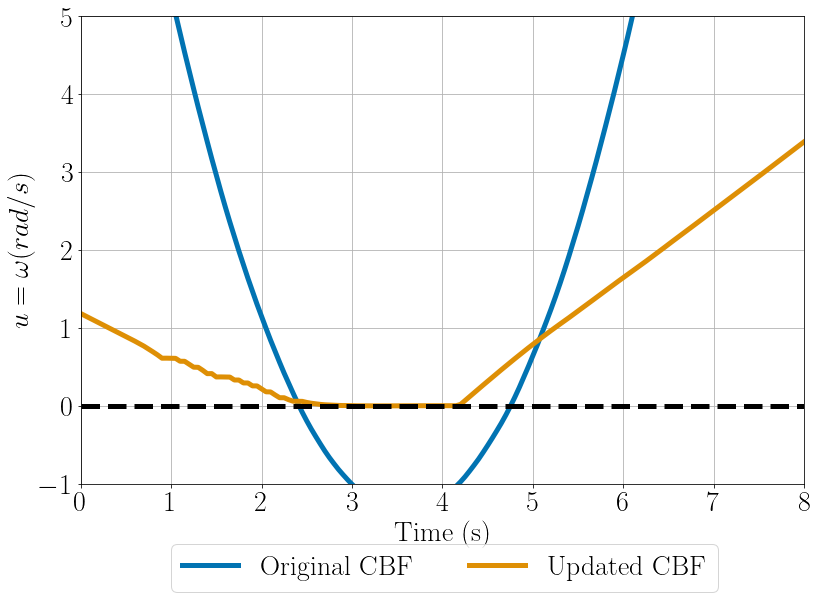

In [71]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.set_palette("colorblind")
ax.plot(ts[:last_idx_2], vf_filt[:last_idx_2], label='Original CBF', linewidth=5)
ax.plot(ts[:last_idx_3], vf_filt_ws[:last_idx_3], label='Updated CBF', linewidth=5)
ax.plot(ts, np.ones_like(ts) * 0.0, '--k', linewidth=5)
ax.set_xlim([0, 8])
ax.set_ylim([-1, 5])
ax.set_xlabel("Time (s)")
ax.set_ylabel("$u=\omega (rad/s)$")
ax.legend(bbox_to_anchor=(0.9, -0.1), ncol=2)
ax.grid()
fig.tight_layout()

In [ ]:
# elem1=go.Isosurface(x=np.array(grid.states[..., 0][::4, ::4, ::4]).ravel(),
#                              y=np.array(grid.states[..., 1][::4, ::4, ::4]).ravel(),
#                              z=np.array(grid.states[..., 2][::4, ::4, ::4]).ravel(),
#                              value=np.array(target_values_hjr[-1][::4, ::4, ::4]).ravel(),
#                              colorscale="jet",
#                              isomin=0,
#                              surface_count=1,
#                              isomax=0)
# elem2 = go.Scatter3d(x=np.array(target[0]), y=np.array(target[1]), z=np.array(target[2]))
# elem3 = go.Scatter3d(x=np.array(states)[:, 0], y=np.array(states)[:, 1], z=np.array(states)[:, 2])
# elem4 = go.Scatter3d(x=np.array(states[0][0]), y=np.array(states[0][1]), z=np.array(states[0][2]))


# fig = go.Figure(data=[elem1, elem2, elem3, elem4])

In [ ]:
# py.offline.iplot(fig, filename='3d-surface-mesh')